In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import seaborn as sns

import plotly.express as px
import mplcursors
import plotly.io as pio


In [2]:
pio.renderers.default = "notebook_connected"

In [ ]:
#wczytanie danych
dane = pd.read_csv("US_Election_dataset_v1.csv", sep=',')
print(dane.dtypes)

full_name                                                                     object
county                                                                        object
state                                                                         object
2020 Democrat vote raw                                                         int64
2020 Democrat vote %                                                         float64
2020 Republican vote raw                                                       int64
2020 Republican vote %                                                       float64
2020 other vote raw                                                            int64
2020 other vote %                                                            float64
Population with less than 9th grade education                                 object
Population with 9th to 12th grade education, no diploma                       object
High School graduate and equivalent                              

In [4]:
# Usunięcie znaku '%' i konwersja na liczby zmiennoprzecinkowe
kolumny_edukacja = [
    'Population with less than 9th grade education',
    'Population with 9th to 12th grade education, no diploma',
    'High School graduate and equivalent',
    'Some College,No Degree',
    'Associates Degree',
    'Bachelors Degree',
    'Graduate or professional degree'
]

for kolumna in kolumny_edukacja:
    dane[kolumna] = dane[kolumna].str.replace('%', '').astype(float)

In [5]:
# Wybranie kluczowych kolumn do analizy korelacji
kolumny_korelacja = kolumny_edukacja + [
    '2020 Democrat vote %',
    '2020 Republican vote %',
    '2020 other vote %'
]

# Obliczenie macierzy korelacji
korelacja = dane[kolumny_korelacja].corr()
#print(korelacja)

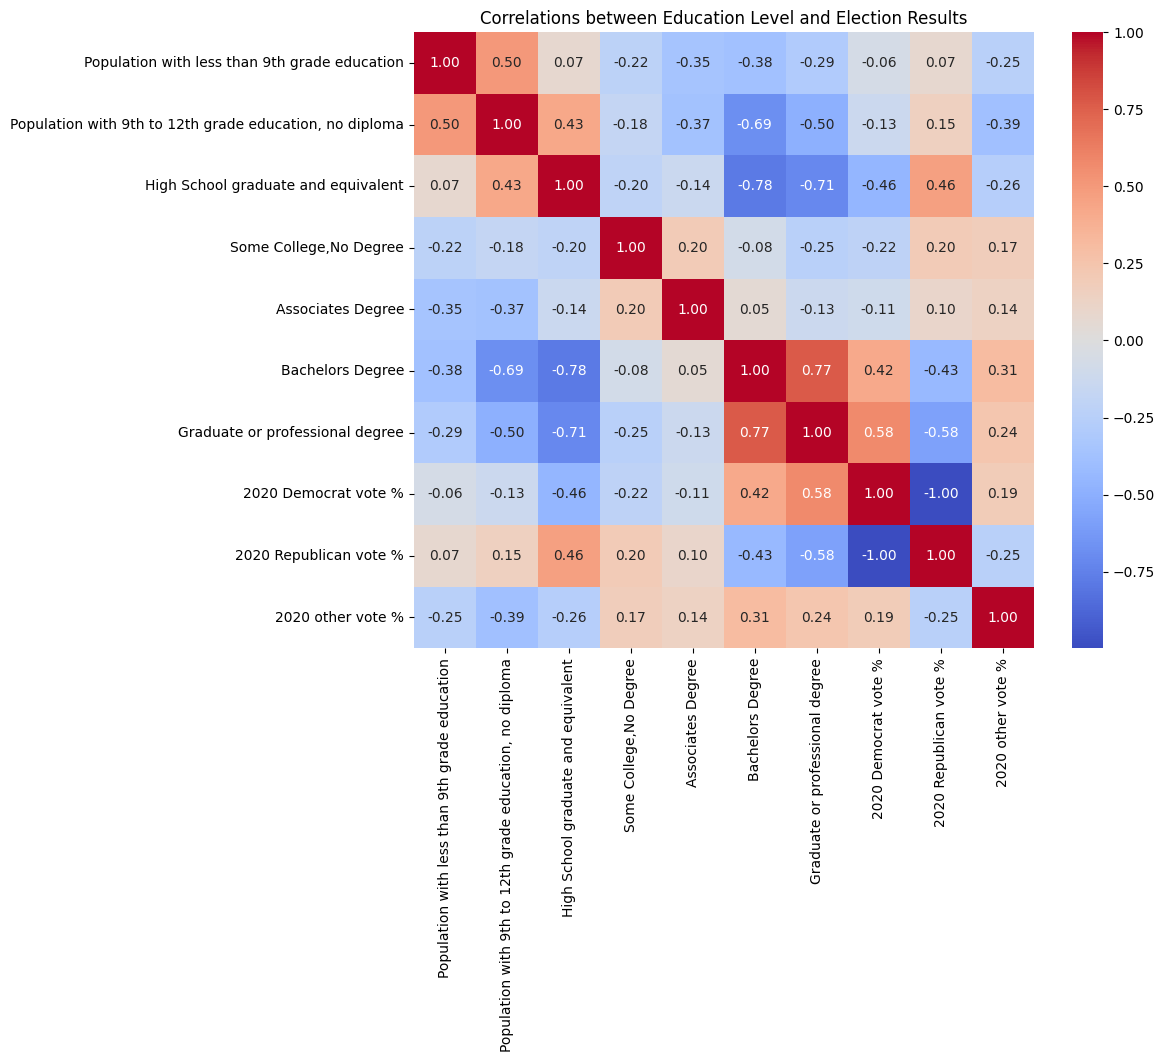

In [6]:
# Wykres korelacji
plt.figure(figsize=(10, 8))
sns.heatmap(korelacja, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlations between Education Level and Election Results")
plt.show()


#### Na wykresie można łatwo zauważyć korelacją pomiędzy wykształceniem a poparciem dla danej partii. Dodatnia korelacja występuje pomiędzy niższym wykształceniem a poparciem dla partii Republikańskiej oraz wyższym wykształceniem a poparciem dla partii demokratycznej. Epicentrum trendu występuje dla wykształcenia średniego (-0,46, 0,46). Na niższych stopniach wykształcenia dominuje poparcie dla republikanów, natomiast osoby o wyższym wykształceniu preferują republikanów. 
#### Najwyższa różnica występuje dla osób z wyższym wykształceniem od 2 stopnia. Współczynnik korelacji wynosi w tym miejscu kolejno 0,58 i -0,58 dla demokratów i republikanów. Ocenia się to jako umiarkowaną korelację. 
#### Inne partie miały największe poparcie wśród osób z wykształceniem wyższym 1 stopnia (inżynier, licencjat) - 0.31.
#### Podsumuwując wykształcenie może być dobrym predytkorem preferencji

In [7]:
# Podział na grupy: wysoki odsetek wykształcenia wyższego
progi = dane['Bachelors Degree'].median()  
dane['High Education'] = dane['Bachelors Degree'] > progi

# Średnie wyniki wyborcze w grupach
srednie_wyniki = dane.groupby('High Education')[['2020 Democrat vote %', '2020 Republican vote %', '2020 other vote %']].mean()
print(srednie_wyniki)

                2020 Democrat vote %  2020 Republican vote %  \
High Education                                                 
False                      29.003848               69.449156   
True                       37.849668               60.104898   

                2020 other vote %  
High Education                     
False                    1.547041  
True                     2.043584  


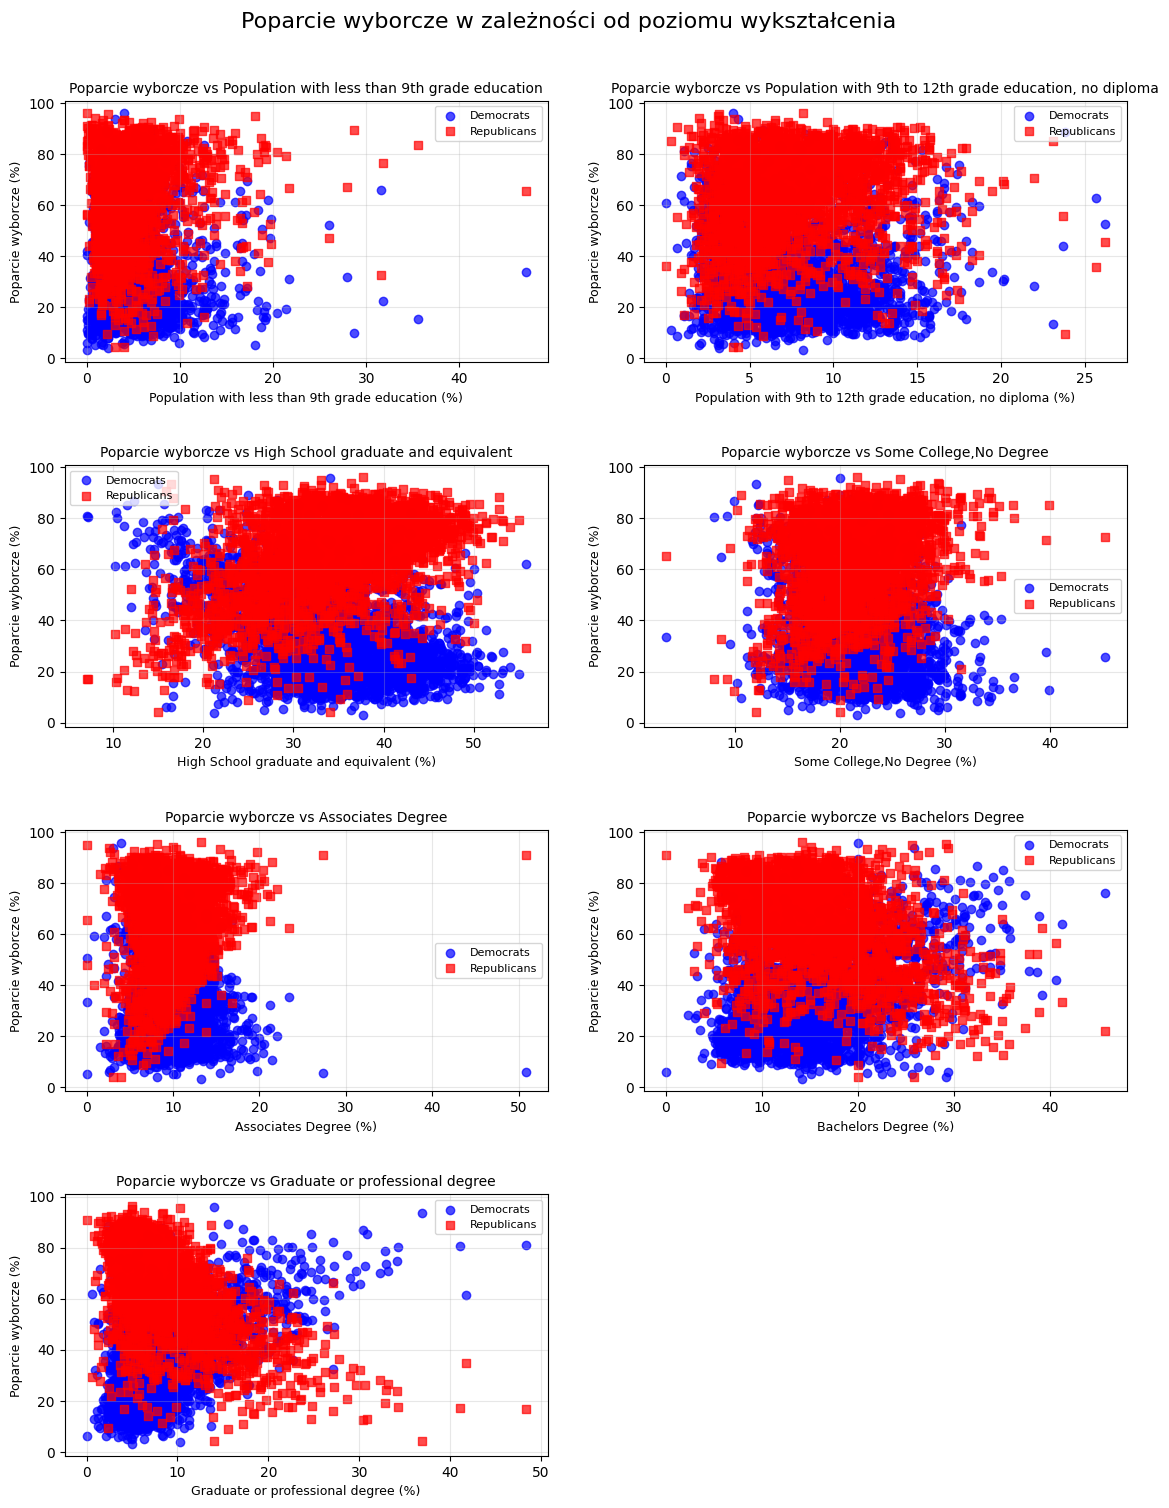

In [8]:
plt.figure(figsize=(12, 15))  # Zmiana wielkości figury na bardziej wydłużoną

# Kolory i style markerów
kolory = ['blue', 'red']
markery = ['o', 's']

# Liczba wierszy i kolumn
liczba_wierszy = 4
liczba_kolumn = 2

# Tworzenie wykresów dla każdego poziomu edukacji
for i, kolumna in enumerate(kolumny_edukacja):
    plt.subplot(liczba_wierszy, liczba_kolumn, i + 1)  # Siatka z 2 kolumnami
    plt.scatter(dane[kolumna], dane['2020 Democrat vote %'], color=kolory[0], marker=markery[0], alpha=0.7, label='Democrats')
    plt.scatter(dane[kolumna], dane['2020 Republican vote %'], color=kolory[1], marker=markery[1], alpha=0.7, label='Republicans')
    
    # Dodanie tytułu i etykiet
    plt.title(f'Poparcie wyborcze vs {kolumna}', fontsize=10)
    plt.xlabel(f'{kolumna} (%)', fontsize=9)
    plt.ylabel('Poparcie wyborcze (%)', fontsize=9)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=8)

plt.tight_layout(pad=3.0)  # Większe odstępy między wykresami
plt.suptitle('Poparcie wyborcze w zależności od poziomu wykształcenia', fontsize=16, y=1.02)
plt.show()


In [9]:
# dane_srednie = dane.groupby('state').mean(numeric_only=True).reset_index()
# plt.figure(figsize=(12, 15))  # Zmiana wielkości figury na bardziej wydłużoną

# # Tworzenie wykresów dla każdego poziomu edukacji
# for i, kolumna in enumerate(kolumny_edukacja):
#     plt.subplot(4, 2, i + 1)  # Siatka z 2 kolumnami
#     plt.scatter(dane_srednie[kolumna], dane_srednie['2020 Democrat vote %'], color='blue', marker='o', alpha=0.7, label='Democrats')
#     plt.scatter(dane_srednie[kolumna], dane_srednie['2020 Republican vote %'], color='red', marker='s', alpha=0.7, label='Republicans')
    
#     # Dodanie tytułu i etykiet
#     plt.title(f'Electoral support vs {kolumna}', fontsize=10)
#     plt.xlabel(f'{kolumna} (%)', fontsize=9)
#     plt.ylabel('Electoral support (%)', fontsize=9)
#     plt.grid(alpha=0.3)
#     plt.legend(fontsize=8)

# plt.tight_layout(pad=3.0)  # Większe odstępy między wykresami
# plt.suptitle("Electoral support depending on education level for all states", fontsize=16, y=1.02)
# plt.show()

In [10]:
dane_srednie = dane.groupby('state').mean(numeric_only=True).reset_index()

# Iteracja po kolumnach edukacji i tworzenie wykresów interaktywnych
for kolumna in kolumny_edukacja:
    fig = px.scatter(
        dane_srednie,
        x=kolumna,
        y=['2020 Democrat vote %', '2020 Republican vote %'],
        labels={kolumna: f'{kolumna} (%)', 'value': 'Electoral support (%)'},
        title=f'Electoral support vs {kolumna}',
        hover_data=['state'],  # Dodanie nazwy stanu do podpowiedzi
    )
    fig.show()

In [11]:
# Wczytanie danych do mapy
dane2 = pd.read_csv("1976-2020-president.csv", sep=';')
#dane2

In [12]:
# Wyciągnięcie danych z 2020 roku
dane_2020 = dane2[dane2.iloc[:, 0] == 2020]
#dane_2020

In [13]:
# Wczytanie mapy USA
usa = gpd.read_file("ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp")
#usa

In [14]:
# Wybieranie wiersz z maksymalną liczbą głosów (candidatevotes) dla każdego stanu
max_votes_per_state = dane_2020.loc[dane_2020.groupby('state')['candidatevotes'].idxmax()]
#print(max_votes_per_state)

In [15]:
# Oczyszczanie nazw stanów (usuwanie zbędnych spacji i konwersja na wielkie litery)
usa['name'] = usa['name'].str.strip().str.upper()
max_votes_per_state['state'] = max_votes_per_state['state'].str.strip().str.upper()

# Złączenie danych
map_data = usa.set_index('name').join(max_votes_per_state.set_index('state'))

# Sprawdzenie wyników
#print(map_data)


In [16]:
# Złączenie tabel
map_data = usa.set_index('name').join(max_votes_per_state.set_index('state'))

In [17]:
candidate_colors = {
    'BIDEN, JOSEPH R. JR': '#1f77b4',  
    'TRUMP, DONALD J.': '#d62728',     
    'Other': '#7f7f7f'                 
}


In [18]:
# Dodanie koloru na podstawie zwycięzcy
map_data['color'] = map_data['candidate'].map(candidate_colors)

In [19]:
map_data["name"] = [
    "MINNESOTA", "MONTANA", "NORTH DAKOTA", "HAWAII", "IDAHO",
    "WASHINGTON", "ARIZONA", "CALIFORNIA", "COLORADO", "NEVADA",
    "NEW MEXICO", "OREGON", "UTAH", "WYOMING", "ARKANSAS",
    "IOWA", "KANSAS", "MISSOURI", "NEBRASKA", "OKLAHOMA",
    "SOUTH DAKOTA", "LOUISIANA", "TEXAS", "CONNECTICUT", "MASSACHUSETTS",
    "NEW HAMPSHIRE", "RHODE ISLAND", "VERMONT", "ALABAMA", "FLORIDA",
    "GEORGIA", "MISSISSIPPI", "SOUTH CAROLINA", "ILLINOIS", "INDIANA",
    "KENTUCKY", "NORTH CAROLINA", "OHIO", "TENNESSEE", "VIRGINIA",
    "WISCONSIN", "WEST VIRGINIA", "DELAWARE", "DISTRICT OF COLUMBIA",
    "MARYLAND", "NEW JERSEY", "NEW YORK", "PENNSYLVANIA", "MAINE",
    "MICHIGAN", "ALASKA"
]

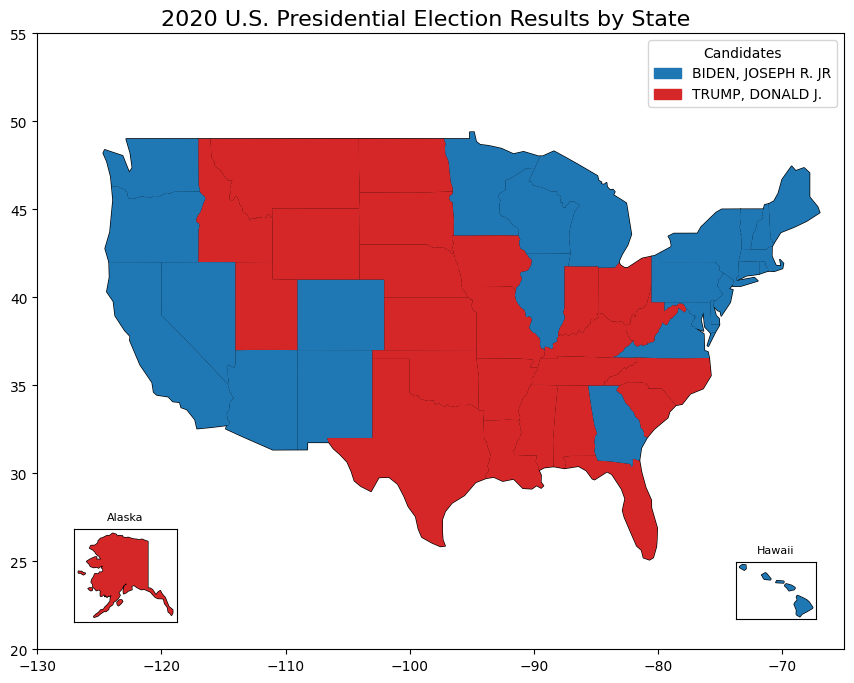

In [20]:
# Główna mapa (kontynentalne USA)
fig, ax = plt.subplots(figsize=(12, 8))
usa.plot(ax=ax, color='lightgrey', edgecolor='black')
map_data.plot(ax=ax, color=map_data['color'])
ax.set_xlim([-130, -65])  # Zakres dla kontynentalnych USA
ax.set_ylim([20, 55])

# Tytuł główny mapy na środku
fig.suptitle('2020 U.S. Presidential Election Results by State', fontsize=16, ha='center', y=0.91)

# Dodanie Alaski w okienku
ax_alaska = inset_axes(ax, width="15%", height="15%", loc='lower left', borderpad=2)
alaska = usa[usa['name'] == 'ALASKA']  
alaska_data = map_data[map_data.iloc[:, 3] == 3563]
alaska.plot(ax=ax_alaska, color='lightgrey', edgecolor='black')
alaska_data.plot(ax=ax_alaska, color=alaska_data['color'])
ax_alaska.set_xticks([])
ax_alaska.set_yticks([])
ax_alaska.set_title("Alaska", fontsize=8)

# Dodanie Hawajów w okienku
ax_hawaii = inset_axes(ax, width="10%", height="10%", loc='lower right', borderpad=2)
hawaii = usa[usa['name'] == 'HAWAII']  
hawaii_data = map_data[map_data.iloc[:, 3] == 3517]  
hawaii.plot(ax=ax_hawaii, color='lightgrey', edgecolor='black')
hawaii_data.plot(ax=ax_hawaii, color=hawaii_data['color'])
ax_hawaii.set_xticks([])
ax_hawaii.set_yticks([])
ax_hawaii.set_title("Hawaii", fontsize=8)

# Wyciągnięcie unikalnych kolorów i odpowiadających im etykiet z danych mapy
unique_colors = map_data[['color', 'candidate']].drop_duplicates()

# Tworzenie elementów legendy na podstawie unikalnych wartości
legend_elements = [
    mpatches.Patch(color=row['color'], label=row['candidate'])
    for _, row in unique_colors.iterrows()
]

# Dodanie legendy
ax.legend(handles=legend_elements, title="Candidates", loc='upper right')

# Wyświetlenie mapy
plt.show()


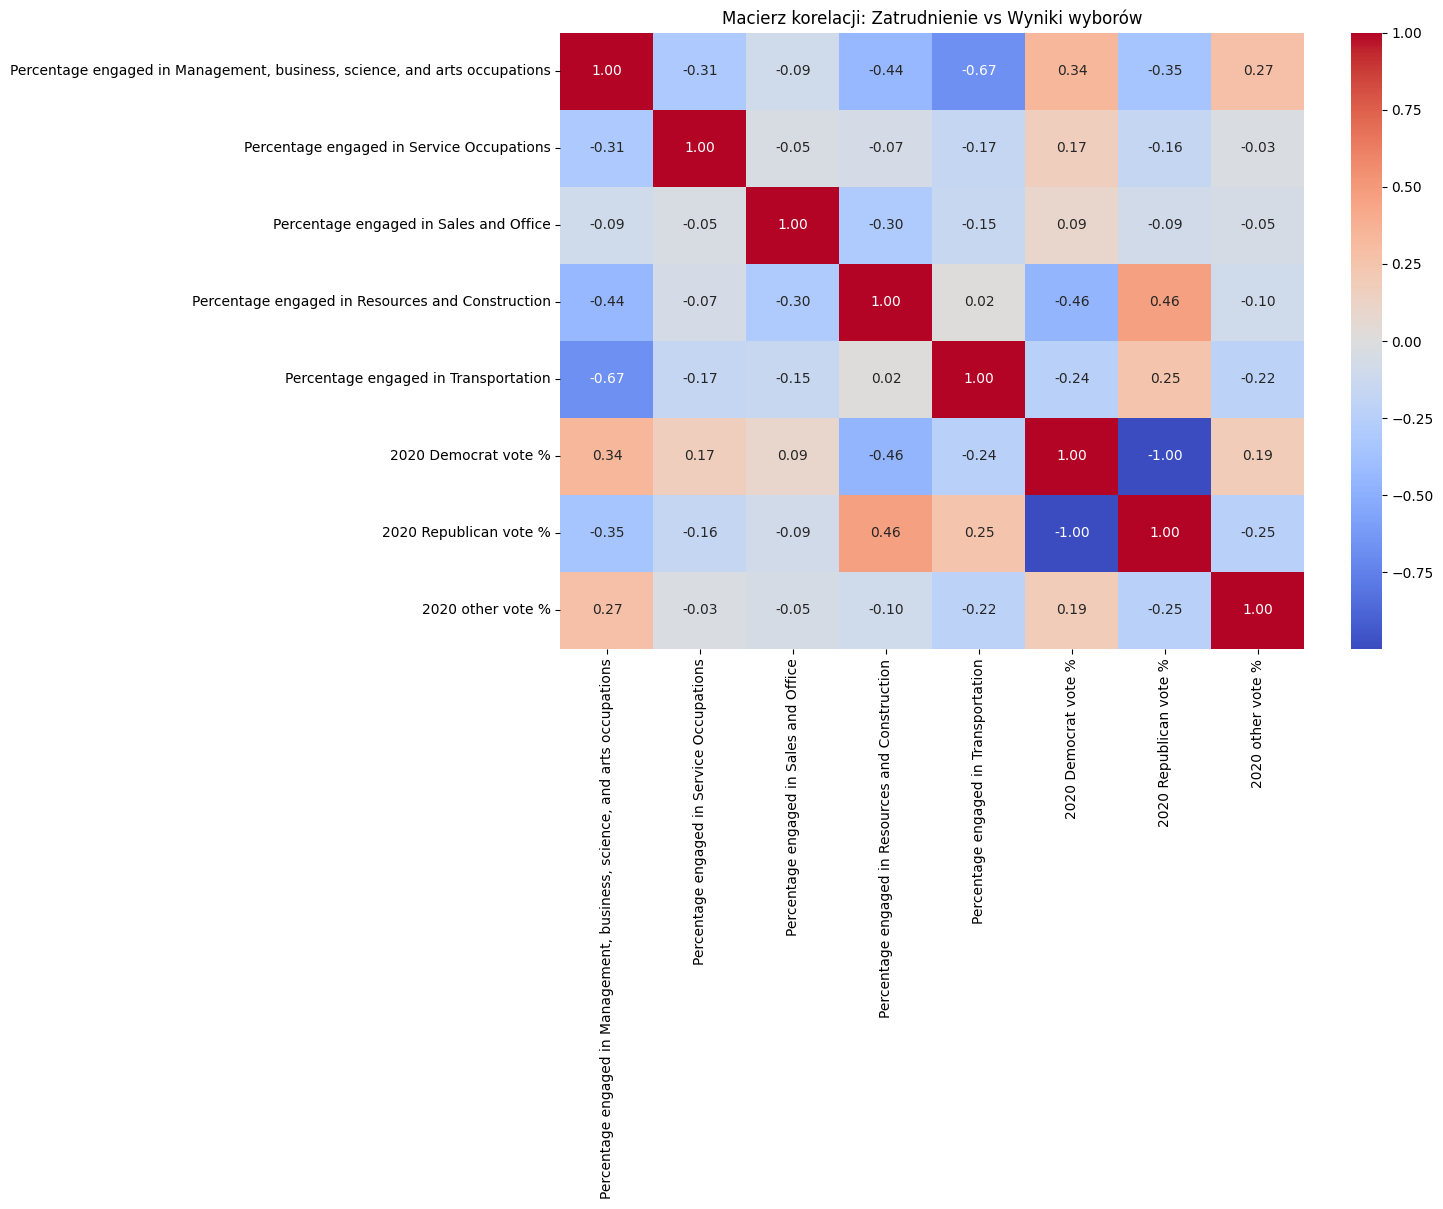

In [22]:
# Kolumny związane z zatrudnieniem
kolumny_zatrudnienie = [
    'Percentage engaged in Management, business, science, and arts occupations',
    'Percentage engaged in Service Occupations',
    'Percentage engaged in Sales and Office',
    'Percentage engaged in Resources and Construction',
    'Percentage engaged in Transportation'
]

# Wyniki wyborów
kolumny_wyniki = [
    '2020 Democrat vote %',
    '2020 Republican vote %',
    '2020 other vote %'
]

# Tworzenie macierzy korelacji dla sektorów zatrudnienia i wyników wyborów
data_korelacja = dane[kolumny_zatrudnienie + kolumny_wyniki]
korelacja_zatrudnienie = data_korelacja.corr()

# Wizualizacja macierzy korelacji
plt.figure(figsize=(12, 8))
sns.heatmap(korelacja_zatrudnienie, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Macierz korelacji: Zatrudnienie vs Wyniki wyborów")
plt.show()



In [24]:
# Grupowanie danych po stanie i obliczanie średnich wartości
dane_srednie = dane.groupby('state').mean(numeric_only=True).reset_index()

# Iteracja po kolumnach zatrudnienia i tworzenie wykresów interaktywnych
for sektor in kolumny_zatrudnienie:
    fig = px.scatter(
        dane_srednie,
        x=sektor,
        y=kolumny_wyniki,  # Kolumny z wynikami wyborczymi
        labels={
            sektor: f'{sektor} (%)',
            'value': 'Electoral support (%)'
        },
        title=f'Electoral support by Employment Sector: {sektor}',
        hover_data=['state'],  # Dodanie informacji o stanie
    )
    fig.show()